# Emotion expression

In [2]:
!pip install keras

  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import sys
from keras.models import load_model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers



def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

Using TensorFlow backend.


# 1. dataset

In [4]:
df = pd.read_csv("./emotion/fer2013.csv")
df.head()

#  0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral**

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.shape

(35887, 3)

#### data 분포

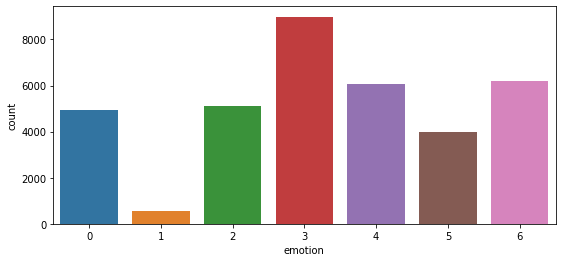

In [6]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [14]:
image_size=(48,48)

In [15]:
pixels = df['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
  face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
  face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
  faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form
  
faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension

In [16]:
emotions = pd.get_dummies(df['emotion']).to_numpy()

(35887, 48, 48, 1)
(35887, 7)


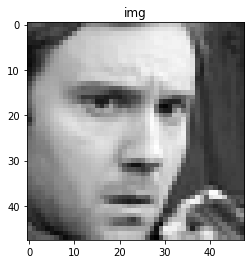

In [17]:
print(faces.shape)
print(emotions.shape)
img = faces[0,:,:,0]
imshow("img", img)

#### 정규화(-1~1)

In [42]:
x = faces.astype('float32')
x = x / 255.0 #Dividing the pixels by 255 for normalization

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0

In [43]:
num_samples = x.shape[0]
print(num_samples)                 

35887


#### split train/ val

In [24]:
num_samples, num_classes = emotions.shape
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
train_x = x[:num_train_samples]
train_y = emotions[:num_train_samples]

# Validation data
val_x = x[num_train_samples:]
val_y = emotions[num_train_samples:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

In [25]:
print('Training Pixels',train_x.shape)
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


In [26]:
input_shape=(48, 48, 1)
num_classes = 7

#### data generator
- 보통 +- 10%정도

In [32]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# 2. model

### h5, hdf5: 같음.
> h5

> hdf5
- 계층적 데이어 프레임
- 계층적으로 되어있는 대용량 데이터 포맷
- update는 불가

In [21]:
model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax',name='predictions'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



#### global average pooling
> pooling
- sampling 과정
- 인력 pool

> maxpooling
- filter 중 가강 큰 값 사용

> global average pooling
- flatten()이 없음.
- filter 전체의 평균값 사용
- 파라미터 개수가 줄일 수 있음.

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_array (Conv2D)         (None, 48, 48, 16)        800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        12560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 16)       

In [31]:
batch_size = 32
num_epochs = 200
verbose = 1
num_classes = 7 

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#### epoch 200은 되야 성능 나옴

In [40]:
train_faces, train_emotions = train_data
history=model.fit_generator(data_generator.flow(train_faces, train_emotions,
         batch_size), epochs=1, verbose=1,  validation_data=val_data)

Epoch 1/1
898/898 [==============================] - 198s 221ms/step - loss: 1.5686 - accuracy: 0.3829 - val_loss: 1.4332 - val_accuracy: 0.4458


In [36]:
model.save("emotion_temp.h5")
score = model.evaluate(val_x, val_y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

7178/7178 [==============================] - 10s 1ms/step
Test loss: 1.6311038849113977
Test accuracy: 35.0376158952713


# 3. test

In [53]:
def load_detection_model(model_path):
    detection_model = cv2.CascadeClassifier(model_path)
    return detection_model

def detect_faces(detection_model, gray_image_array):
    print(detection_model)
    print(gray_image_array.shape)
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

def draw_bounding_box(face_coordinates, image_array, color):
    x, y, w, h = face_coordinates
    cv2.rectangle(image_array, (x, y), (x + w, y + h), color, 2)

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

def draw_text(coordinates, image_array, text, color, x_offset=0, y_offset=0,
                                                font_scale=0.5, thickness=2):
    x, y = coordinates[:2]
    cv2.putText(image_array, text, (x + x_offset, y + y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, color, thickness, cv2.LINE_AA)
    
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [57]:
image_path = "./emotion/tes.jpg"
detection_model_path = './emotion/haarcascade_frontalface_alt2.xml'
emotion_model_path = './emotion/fer2013_big_XCEPTION.54-0.66.hdf5'
emotion_model_path = "./emotion/emotion_temp.h5"
emotion_labels = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}
font = cv2.FONT_HERSHEY_SIMPLEX

emotion_offsets = (0, 0)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
emotion_target_size = emotion_classifier.input_shape[1:3]

In [58]:
# loading images
rgb_image = cv2.imread("./emotion/tes.jpg")
gray_image = cv2.imread("./emotion/tes.jpg",0)

In [59]:
faces = detect_faces(face_detection, gray_image)

for face_coordinates in faces:   
    
    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]

    gray_face = cv2.resize(gray_face, (emotion_target_size))

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0) # 앞에 1차원 추가    
    gray_face = np.expand_dims(gray_face, -1) # 뒤에 1차원 추가
    
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    emotion_text = emotion_labels[emotion_label_arg]
    
    color = (255, 0, 0)

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, emotion_text, color, -20, -20, 0.7, 2)

cv2.imwrite('./emotion/out.jpg', rgb_image)

<CascadeClassifier 000002662ADF5810>
(912, 736)


True

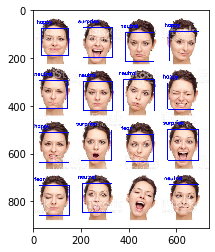

In [60]:
imshow('', rgb_image)